In [1]:
import numpy as np
import nlopt
import pandas as pd
from math import log, exp
from multiprocessing import Pool, cpu_count
import time
import matplotlib.pyplot as plt
#%matplotlib notebook

In [2]:
#needs path to file:
fileIn = "chr19_2000_msprime_crossover_only_infinite_sites.tsv"


In [3]:
def rho(rbp,g,L,d):
    r = rbp*(d+2*(g/rbp)*L*(1 - exp(-d/L)))
    return(r)

In [4]:
def single_dist_obj_fun(r,x):
    d,h0,h1,h2,th = x
    r = r*(d)
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [5]:
def single_dist_multi_ind_obj_fun(r,xl):
    res = [ single_dist_obj_fun(r,xs) for xs in xl]
    res = sum(res)
    return(res)

In [6]:
def find_max_like_single_dist(args):
    d, testChr = args
    opt = nlopt.opt(nlopt.LN_NELDERMEAD,1)
    opt.set_lower_bounds([0.0000001])
    opt.set_upper_bounds([0.5])
    startPoint = [0.001]
    opt.set_max_objective(lambda x, grad: single_dist_obj_fun(x,testChr))
    res = opt.optimize(startPoint)
    return([testChr[0],res[0]])

In [7]:
def calc_single_dist(x,rbp):
    d,h0,h1,h2,th = x
    
    r = rbp*(d)
    
    calcH0 =(18+13*r + r**2 + 36*th + 22*th**2 + 4*th**3 + r*(6*th+th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH2 = (th**2*(36+14*r+r**2+36*th+6*th*r+8*th**2))/((1+th)*(18+13*r+r**2+54*th + 40*th**2+8*th**3+r*(r*th+19*th+6*th**2)))
    calcH1 = 1 - calcH0 - calcH2
    
    val = h0*log(calcH0) + h1*log(calcH1)+h2*log(calcH2)
    return(val)

In [8]:
def single_chr_obj_fun(x_,arr):
    rbp= x_
    test = np.apply_along_axis(lambda x: calc_single_dist(x,rbp),1,arr)
    obfun = np.sum(test)
    #test = [calc_single_dist(x,rbp,g,L) for x in arr]
    #obfun = sum(test)
    return(obfun)

In [9]:
def across_chr_obj_fun(x,dfArrList,numChrs):
    
    rList = x[0:numChrs]
    gList = x[numChrs:numChrs+numChrs]
    L = x[-1]
    
    obFun = sum([single_chr_obj_fun([rs,gs,L],arr) for (rs,gs,arr) in list(zip(rList,gList,dfArrList))])
    
    return(obFun)

In [10]:
def find_max_like_single_ind(rep):
    
    numberChromsomes = 19
    dfListAuto = [ df.loc[(df['chromosome']== x) & (df['replicate']==rep) & (df['sample']==1) & (df['Unnamed: 0']<=10)] for x in list(range(1,numberChromsomes+1))]
    dfListAuto = [x.iloc[:,[0,4,5,6,11]].to_numpy() for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromsomes)]+ [0.0001 for x in range(numberChromsomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromsomes)]+[0.1 for x in range(numberChromsomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromsomes)]+[0.001 for x in range(numberChromsomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromsomes+numberChromsomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromsomes))

    res = opt.optimize(startPoints)
    return(res)

In [11]:
def combine_across_individuals(thisDF):
    test = thisDF
    numSamples = len(test['sample'].unique())
    test = test.groupby(['Unnamed: 0'],as_index=False).sum()
    test['H'] = test['H']/numSamples
    return(test.iloc[:,[0,4,5,6,11]].to_numpy())
    #return( test.iloc[:,[0,4,5,6,11]].to_numpy() )

In [12]:
def find_max_like_group_ind(rep):
    
    numberChromsomes = 19
    dfListAuto = [ df.loc[(df['chromosome']== x) & (df['replicate']==rep) & (df['Unnamed: 0']<=10)] for x in list(range(1,numberChromsomes+1))]
    dfListAuto = [combine_across_individuals(x) for x in dfListAuto]

    lowerBounds = [0.0001 for x in range(numberChromsomes)]+ [0.0001 for x in range(numberChromsomes)]+[10]
    upperBounds = [0.1 for x in range(numberChromsomes)]+[0.1 for x in range(numberChromsomes)]+[2000]
    startPoints = [0.001 for x in range(numberChromsomes)]+[0.001 for x in range(numberChromsomes)]+[50]


    opt=nlopt.opt(nlopt.LN_NELDERMEAD,numberChromsomes+numberChromsomes+1)

    opt.set_lower_bounds(lowerBounds)
    opt.set_upper_bounds(upperBounds)

    opt.set_max_objective(lambda x,grad: across_chr_obj_fun(x,dfListAuto,numberChromsomes))

    res = opt.optimize(startPoints)
    return(res)

In [13]:
def combine_across_individuals_and_replicates(thisDF):
    test = thisDF
    numSamples = len(test['sample'].unique())
    numReplicates = len(test['replicate'].unique())
    test = test.groupby(['Unnamed: 0'],as_index=False).sum()
    test['H'] = test['H']/(numSamples*numReplicates)
    return(test.iloc[:,[0,4,5,6,11]].to_numpy())
    #return( test.iloc[:,[0,4,5,6,11]].to_numpy() )

In [14]:
df = pd.read_csv(fileIn,delimiter='\t')

In [15]:
df = pd.read_csv(fileIn,delimiter='\t')
df = df.loc[ df['chromosome'] != 'X']
df = df.astype({'chromosome':'int64'})

/home/derek/anaconda3/envs/simulation/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [16]:
df

,Unnamed: 0,sample,replicate,chromosome,h_0,h_1,h_2,total,h_0_frac,h_1_frac,h_2_frac,H
0,1,1,1,19,27775561,397262,2853,28175676,0.985799,0.014099,0.000101,0.007151
1,2,1,1,19,27775566,397250,2859,28175675,0.985799,0.014099,0.000101,0.007151
2,3,1,1,19,27775564,397252,2858,28175674,0.985799,0.014099,0.000101,0.007151
3,4,1,1,19,27775548,397282,2843,28175673,0.985799,0.014100,0.000101,0.007151
4,5,1,1,19,27775484,397408,2780,28175672,0.985797,0.014105,0.000099,0.007151
...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1996,10,100,19,27778077,393776,1828,28173681,0.985958,0.013977,0.000065,0.007053
1999996,1997,10,100,19,27778109,393710,1861,28173680,0.985960,0.013974,0.000066,0.007053
1999997,1998,10,100,19,27778098,393730,1851,28173679,0.985959,0.013975,0.000066,0.007053
1999998,1999,10,100,19,27778103,393718,1857,28173678,0.985959,0.013975,0.000066,0.007053


### fitting global model for chr 19 data 

In [37]:
testPooled = df.loc[(df['chromosome']==19) & (df['replicate']<= 100) & (df['Unnamed: 0']<=2000)] 
testPooled = combine_across_individuals_and_replicates(testPooled)

In [40]:
testPooled

array([[1.00000000e+00, 2.77810323e+10, 3.91859645e+08, 2.78409300e+06,
        7.05267606e-03],
       [2.00000000e+00, 2.77810315e+10, 3.91859163e+08, 2.78433100e+06,
        7.05267620e-03],
       [3.00000000e+00, 2.77810286e+10, 3.91863111e+08, 2.78233900e+06,
        7.05267581e-03],
       ...,
       [1.99800000e+03, 2.77781420e+10, 3.93673468e+08, 1.86349500e+06,
        7.05269017e-03],
       [1.99900000e+03, 2.77781443e+10, 3.93667020e+08, 1.86670600e+06,
        7.05268996e-03],
       [2.00000000e+03, 2.77781446e+10, 3.93664326e+08, 1.86805200e+06,
        7.05269018e-03]])

In [17]:
modelTruth = [0.00144168 for d in list(range(0,2000))]
modelConstant = [ 0.00144168 for x in list(range(2000))]
modelEstimatedChr19CombinedReps =  [0.0013988449096676617 for d in list(range(0,2000))]
#we won't use this below, so just make them equal for now:
#modelEstimatedChr19WithGC = [rho(0.0014578211661126998,0.0010329106648468952, 33.196417210391864,d+1)/(d+1) for d in list(range(0,2000))]


##### Here we are trying a single iteration

In [49]:
testChr =  df.loc[(df['chromosome']== 19) & (df['replicate']==10) & (df['sample']==5)& (df['Unnamed: 0']<=500)] 
testChr = testChr.iloc[:,[0,4,5,6,11]].to_numpy()

In [52]:
jobs = [[x+1,testChr[x]] for x in list(range(0,500))]
with Pool(cpu_count()) as p:
    thisResOneInd = p.map(find_max_like_single_dist,jobs)
thisResOneInd = [x[1] for x in thisResOneInd]

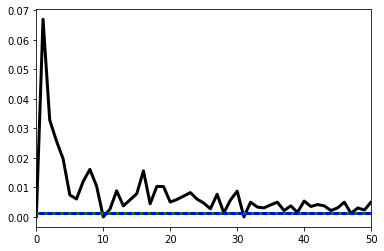

In [53]:
plt.plot(thisResOneInd,"k",linewidth=3)
plt.plot(modelTruth,"b",linewidth=3)
#plt.plot(modelConstant,"y",linewidth=3)
#plt.plot(modelEstimatedGloballyAsMedian,"g",linewidth=3)
plt.plot(modelEstimatedChr19CombinedReps,"g:",linewidth=3)
#plt.plot(modelEstimatedChr19WithGC,"r:",linewidth=3)

plt.xlim([0,50])
plt.show()

Here combining across individuals to get an estimate of Rho/d (r/bp) for each distance  

In [18]:
testPooled = df.loc[(df['chromosome']==19) & (df['replicate']<= 100) & (df['Unnamed: 0']<=2000)] 
testPooled = combine_across_individuals_and_replicates(testPooled)

In [21]:
jobs = [[x+1,testPooled[x]] for x in list(range(1000))]
with Pool(cpu_count()) as p:
    thisRes = p.map(find_max_like_single_dist,jobs)
thisRes = [x[1] for x in thisRes]

In [22]:
print(thisRes)

[1e-07, 1e-07, 0.0002537367431634657, 0.001751040687369618, 0.0009691955856326654, 0.0015097175091740064, 0.0025097309850699574, 0.001353724389648779, 0.0016676963823627994, 0.0021483112133032943, 0.0017748248535163075, 0.0014207686183926032, 0.0015052340193506648, 0.0011679710245290325, 0.0013616886754411917, 0.001623354558939587, 0.0010320488349823671, 0.0012173494882358842, 0.0011226197634693548, 0.0013366057403561046, 0.0013803578496936393, 0.0014040275863650873, 0.0014775371697373348, 0.0015899980125108116, 0.0014710832578827176, 0.00141292447516806, 0.0015313589833780155, 0.0014039875360485482, 0.0014211347927100327, 0.0012623982265475824, 0.0013756715995582136, 0.0013387512929919796, 0.0013213179626468258, 0.0013504030741473335, 0.0012879975302222803, 0.0013537472755377569, 0.001213376282324423, 0.0013064993457794194, 0.0014715867505353877, 0.0015734990228244397, 0.0014845859359737805, 0.0014942781124111582, 0.0013563131777015788, 0.001326209822654383, 0.001367650456618922, 0.00

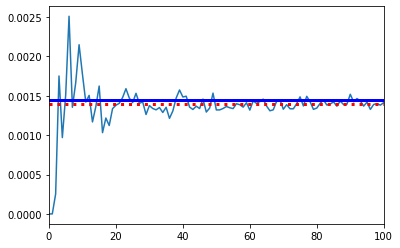

In [23]:
plt.plot(thisRes)
plt.plot(modelTruth,"b",linewidth=3)
#plt.plot(modelConstant,"y",linewidth=3)
#plt.plot(modelEstimatedGloballyAsMedian,"g",linewidth=3)
plt.plot(modelEstimatedChr19CombinedReps,"r:",linewidth=3)
#plt.plot(modelEstimatedChr19WithGC,"k:",linewidth=3)
plt.xlim([0,100])
plt.show()